In [192]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np 
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import plots

In [193]:
class RITZ(nn.Module):
    def __init__(self, input_dim, layers, fact, activation_function=nn.Tanh()):
        super(RITZ, self).__init__()
        
        self.input_dim = input_dim
        self.activation_function = activation_function
        
        # Fourier frequencies for encoding dirichlet boundary conditions
        self.ks = 2**torch.arange(0, fact+1).unsqueeze(0)
        self.adjusted_layers = [2*(fact+1)*input_dim] + layers + [1]
        
        self.linears = nn.ModuleList([nn.Linear(self.adjusted_layers[i], self.adjusted_layers[i+1])
                                      for i in range(len(self.adjusted_layers)-1)])
        self._param_init()
        
    def _param_init(self):
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('tanh'))
                nn.init.constant_(m.bias, 0.1)

    def _fourier_features(self, x):
        N, d = x.shape

        x = x.unsqueeze(-1)
        x_pi_ks = x * self.ks * torch.pi
        ff_x = torch.cat([torch.sin(x_pi_ks), torch.cos(x_pi_ks)], dim=2)
        
        return ff_x.view(N, -1)

        
    def forward(self, x: torch.Tensor):
        fft_g = self._fourier_features(x)
        z = fft_g

        for i in range(len(self.adjusted_layers)-2):
            z = self.linears[i](z)
            z = self.activation_function(z)

        z = self.linears[-1](z)
        # z = z * fft_g
        z = torch.mean(z, 1, keepdim=True)
        
        return z


In [194]:
class Omega2D(Dataset):
    def __init__(self, n_omega=100, n_boundary=75, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.n_omega = n_omega
        self.n_boundary = n_boundary
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train, self.integration_points = self._create_points_for_training()

    def _create_points_for_training(self):
        xmin, xmax = self.x_bounds
        ymin, ymax = self.y_bounds

        x = np.random.uniform(xmin, xmax, self.n_omega)
        y = np.random.uniform(ymin, ymax, self.n_omega)
        omega_coordinates = np.column_stack((x, y))

        n_per_boundary = self.n_boundary//4
        x_left, y_left = xmin*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_right, y_right = xmax*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, n_per_boundary), ymin*np.ones(n_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, n_per_boundary), ymax*np.ones(n_per_boundary)
        x_boundary = np.concatenate((x_left, x_right, x_bottom, x_top))
        y_boundary = np.concatenate((y_left, y_right, y_bottom, y_top))
        boundary_coordinates = np.column_stack((x_boundary, y_boundary))

        integration_points = np.concatenate((omega_coordinates, boundary_coordinates))

        return omega_coordinates, boundary_coordinates, integration_points

In [195]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, ux_omega, fx, ux_boundary, cl_boundary, reg_boundary=500):
        grad_u = torch.autograd.grad(inputs=x_omega, outputs=ux_omega, grad_outputs=torch.ones_like(ux_omega), create_graph=True)[0]
        grad_ux1, grad_ux2 = grad_u[:, 0], grad_u[:, 1]
        
        physical_term1 = (grad_ux1.pow(2) + grad_ux2.pow(2)).view(-1, 1)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 4/2*physical_term1.mean()
        loss_term2 = 4*physical_term2.mean()
        loss_term3 = boundary_term.mean()

        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3

In [ ]:
class PB54():
    def __init__(self, model, config=None):
        self.model = model
        self.criterion = DeepRitzLoss()
        if config == 'MC Grid':
            self.train = self.train_mc_grid
        elif config == 'Uniform Grid':
            self.train = self.train_uniform_grid

    def cl_boundary(self, x):
        return torch.zeros(x.shape[0], 1)

    def fx(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        fx = 2*(torch.pi**2) * torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)
        # fx = 2*(1-x2**2) + 2*(1-x1**2)
        return fx.view(-1, 1)
    
    def ux(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        ux = torch.sin(torch.pi * x1) * torch.sin(torch.pi * x2)
        # ux = (1-x1**2)*(1-x2**2)
        return ux
    
    def _init_criterion(self, optimizer='Adam', lr=1e-2):
        if optimizer == 'Adam':
            model_optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        elif optimizer == 'LBFGS':
            model_optimizer = torch.optim.LBFGS(self.model.parameters(), lr=lr, line_search_fn='strong_wolfe', max_iter=20)
        else:
            raise ValueError("Unsupported optimizer. Use 'Adam' or 'LBFGS'.")
        return model_optimizer
    
    def train_mc_grid(self, n_iter, n_omega, n_boundary, beta, optimizer='Adam', lr=1e-2):
        criterion = self.criterion
        model_optimizer = self._init_criterion(optimizer, lr)
        
        self.model.train()
        last_loss = [None]

        for iter_i in range(n_iter):
            X = Omega2D(n_omega=n_omega, n_boundary=n_boundary)
            x_omega = torch.tensor(X.omega_train, dtype=torch.float32, requires_grad=True)
            x_boundary = torch.tensor(X.boundary_train, dtype=torch.float32)
            fx_omega = self.fx(x_omega)
            cl_boundary = self.cl_boundary(x_boundary)
            
            def closure():
                model_optimizer.zero_grad()
                ux_omega = self.model(x_omega)
                ux_boundary = self.model(x_boundary)
                loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary, beta)

                loss.backward(retain_graph=(optimizer == 'LBFGS'))
                last_loss[0] = loss.item()
                return loss
            
            if optimizer == 'LBFGS':
                model_optimizer.step(closure)
            else:
                loss = closure()
                model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {last_loss[0]}')
    
    def _generate_grid(self, grid_size):
        x = torch.linspace(-1, 1, grid_size)
        y = torch.linspace(-1, 1, grid_size)
        xx, yy = torch.meshgrid(x, y)
        grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)
        return grid
    
def plot_metrics(pb, grid_size):
    mesh_coordinates = pb._generate_grid(grid_size)
    mesh_coordinates.requires_grad = True

    model = pb.model.eval()
    u_pred = model(mesh_coordinates).view(-1)
    u_exact = pb.ux(mesh_coordinates).view(-1)

    u_pred_reshaped = u_pred.view(grid_size, grid_size).detach().numpy()
    u_exact_reshaped = u_exact.view(grid_size, grid_size).detach().numpy()

    err_relative_l2 = plots.compute_l2_relative_error(u_pred, u_exact)
    err_relative_h1 = plots.compute_h1_relative_error(u_pred, u_exact, mesh_coordinates)

    fig0 = plots.plot_config1(u_pred_reshaped, u_exact_reshaped, 'U')

In [200]:
X = Omega2D(n_omega=1000)
model = RITZ(input_dim=2, layers=[10], fact=4)
print(model.linears)

pb54 = PB54(model, config='MC Grid')
pb54.train(n_iter=4000, n_omega=1000, n_boundary=400, beta=500, optimizer='Adam', lr=1e-2)
# pb54.train(n_iter=1000, n_omega=1000, n_boundary=400, beta=500, optimizer='LBFGS', lr=1e-2)

ModuleList(
  (0): Linear(in_features=20, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=1, bias=True)
)
Iteration 0, loss: 4026.3623046875
Iteration 100, loss: 35.83006286621094
Iteration 200, loss: 7.37937068939209
Iteration 300, loss: 1.9248650074005127
Iteration 400, loss: 0.33107686042785645
Iteration 500, loss: -0.0883416160941124
Iteration 600, loss: -0.27131468057632446
Iteration 700, loss: -0.31244146823883057
Iteration 800, loss: -0.36683568358421326
Iteration 900, loss: -0.41111546754837036
Iteration 1000, loss: -0.7705518007278442
Iteration 1100, loss: -0.5852943062782288
Iteration 1200, loss: -0.999061107635498
Iteration 1300, loss: -1.488766074180603
Iteration 1400, loss: -2.3084723949432373
Iteration 1500, loss: -4.52334451675415
Iteration 1600, loss: -7.927916049957275
Iteration 1700, loss: -7.908331871032715
Iteration 1800, loss: -8.245064735412598
Iteration 1900, loss: -9.432550430297852
Iteration 2000, loss: -9.474075317382812
Iteration 2100, 

(10, 10) (10, 10)
l2_relative_error: 0.06973295894897438, l2_u_true: 4.499999046325684, l2_u_pred: 4.277431488037109
h1_relative_error: 0.19885118076552546, h1_u_true: 22.556493759155273, h1_u_pred: 22.098379135131836


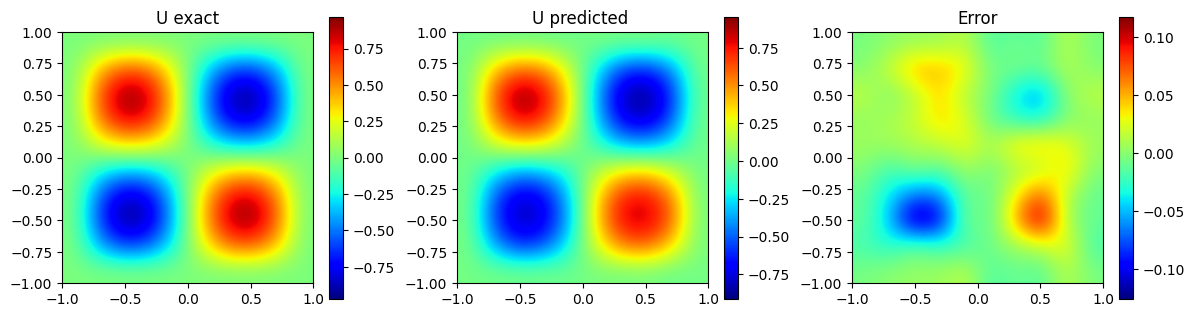

In [209]:
plot_metrics(pb54, grid_size=10)